# Unit 4 Capstone - News Article Analysis & Classification

## John A. Fonte

---
---

### Instructions

1. Find 100 different entries from at least 10 different authors (articles?)
2. Reserve 25% for test set
3. cluster vectorized data (go through a few clustering methods)
4. Perform unsupervised feature generation and selection
5. Perform supervised modeling by classifying by author
6. Comment on your 25% holdout group. Did the clusters for the holdout group change dramatically, or were they consistent with the training groups? Is the performance of the model consistent? If not, why?
7. Conclude with which models (clustering or not) work best for classifying texts.

---
---

### About the Dataset

__Source:__ https://archive.ics.uci.edu/ml/datasets/Reuter_50_50#

__Description:__ This is a subset of the [Reuters Corpus Volume 1 (RCV1)](https://scikit-learn.org/0.17/datasets/rcv1.html). Specifically, this subset consists of the top 50 authors by article proliferation, with a total of 100 articles per each author within the combined training and testing sets.

---
---
# 1. Data Load and Cleaning

In [1]:
# basic imports
# will be doing other imports ad hoc
##### i.e., models and related functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [29]:
'''
Loading Data from Local Computer
Each author is a subfolder, and within each folder is a series of .txt files
The goal of this cell is to load all the contents of every subfolder into the 
DataFrame, while retaining the author designation for those works.
'''

from os import listdir

def multiple_file_load(file_directory):
    
    # identifying all author subfolders - appending them into list 
    
    authorlist = []
    textlist = []
    
    for author in listdir(file_directory):
        authorname = str(author)
        author_sub_directory = (file_directory + '/' + author) #author file path
    
    # identifying all files within each subfolder - 
    
        for filename in listdir(author_sub_directory):
            text_file_path = (author_sub_directory + '/' + filename) # text file path
            
            if (filename.lower().endswith('txt')):
                authorlist.append(authorname)
                textfile = open(text_file_path,'r') # this is how you open files
                substantive_text = textfile.read()  # this is how to read a file
                textlist.append(substantive_text)   # this is how to do something with that file
                textfile.close()                    # this is how to close the file 
                                                             # (you must close one before opening another!)
  # pushing the two lists into a dataframe 

    df = pd.DataFrame({'Author':authorlist, 'Text':textlist})
    
    return df
                

In [30]:
# loading training data (note the file path)
df_train = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50train')

In [31]:
df_train.head(3)

,Author,Text
0,AaronPressman,The Internet may be overflowing with new techn...
1,AaronPressman,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,Elementary school students with access to the ...


In [32]:
# Authors don't have space between the names
# adding the space in the authors...because I want it
import re
author_split = [re.findall('[A-Z][a-z]*', i) for i in df_train.Author]

In [33]:
#joining them back together
author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    

In [34]:
df_train['Author'] = pd.Series(author_join)
df_train.tail(3)

,Author,Text
2497,William Kazer,China issued tough new rules on the handling o...
2498,William Kazer,China will avoid bold moves in tackling its ai...
2499,William Kazer,Communist Party chief Jiang Zemin has put his ...


In [35]:
# Loading df_test, which is a separate csv file

df_test = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50test')
df_test.head(3)

,Author,Text
0,AaronPressman,U.S. Senators on Tuesday sharply criticized a ...
1,AaronPressman,Two members of Congress criticised the Federal...
2,AaronPressman,Commuters stuck in traffic on the Leesburg Pik...


In [36]:
#another fix to Author column

author_split = [re.findall('[A-Z][a-z]*', i) for i in df_test.Author]

author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    
    
df_test['Author'] = pd.Series(author_join)

In [37]:
#Before I begin adding features, assignment asks for 25% data split, NOT 50/50
# See "GOAL" below for explanation as to how I am doing that.

'''GOAL:
Trying to get half of the datapoints OF EACH AUTHOR
in the testing set into a new DataFrame, which
will be concatenated onto the training set.
I will delete that from the testing set later.

Doing this instead of combining both and splitting 75/25 later 
ensures balanced data between the authors.
'''

def appendingdataframe(dataframe):
    appendabledataframe = pd.DataFrame(columns=['Author', 'Text'])
    
    for item in dataframe.Author.unique():
        df_testauthor = df_test[df_test['Author'] == item].copy() 
        appendabledataframe = appendabledataframe.append(df_testauthor[25:], 
                                                         ignore_index=True) # want half of df_testauthor!
    
    return appendabledataframe
    

In [38]:
# using appendabledataframe to avoid screwing up original data
# This is explicit inefficiency at the cost of being cautious

df_train2 = df_train.append(appendingdataframe(df_train), ignore_index=True)

# checking if the appending worked
len(df_train2)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

3750

In [39]:
# It worked!
df_train = df_train2.copy()

In [40]:
# doing same for df_test

df_test2 = df_test.append(appendingdataframe(df_train), ignore_index=True)

# checking if the appending worked
len(df_test2)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

3750

In [41]:
# and now to drop the rows added to df_train from df_test

df_test2.drop_duplicates(keep=False, inplace=True)
len(df_test2)

1250

In [42]:
df_test = df_test2.copy()

# Text Cleaning

Arguably the most important part about working with text data is how to refine it for processing. As simple as they are, string substitutions such as `pd.replace` and regex's `re.sub` are common. I am also partial to `pd.Series.apply(lambda x: x.replace('...',''))`.  Additional text processing such as the exclusion of stop_words and lemmatization will be done after the raw text is pre-processed.

In [178]:
# cleaning text before feature analysis/engineering 

#--------------------------------------------------------------------

# CLEANING FUNCTION 1 - WORD AND PUNCTUATION/CHARACTER CLEANING

# EDIT: During first run-through, this function was very basic
# I have since implemented new cleaning features

# regex already imported as re

def text_cleaner(text):
    text = text.lower() # avoiding capitalization problems.
    
    text = re.sub(r'.\s*\\n[a-z]', r'\. [a-z]', text)
    text = re.sub(r'\.\s?([a-z])', r'\. \1', text)
    text = re.sub(r' u\. s\.(\s?)', r' u\.s\.\1', text) # next three lines are my attempt to join 'u. s.' to 'u.s.'
    text = text.replace('u. s.', 'u.s.')
    text = text.replace(r'u. s.', r'u.s.')
    text = re.sub(r'-', '', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub('[\[].*?[\]]', '', text)
    text = re.sub('.=.', '. .', text)
    text = text.replace('\\', '')
    text = re.sub(',', '', text) # I don't want punct screwing up lemmatization
    text = re.sub('\\n', '', text)
    text = re.sub(r'\\n', '', text) # I don't know which one works
    text = text.replace('\"', '')
    
    # rest of punctuation will be handled via lemmatization
    
    return text

In [179]:
# application of text cleaning functions

df_train['Text1'] = df_train['Text'].apply(lambda x: text_cleaner(x))
df_test['Text1'] = df_test['Text'].apply(lambda x: text_cleaner(x))

In [180]:
df_train['Text1'][1]

"the u. s. postal service announced wednesday a plan to boost online commerce by enhancing the security and reliability of electronic mail traveling on the internet. under the plan businesses and consumers can verify that email has not been tampered with and use services now available for ordinary mail like sending a certified letter.the leap from trading messages to buying and selling goods has been blocked by the fear of security threats robert reisner vice president of stategic planning said. to expand from local area networks and bilateral secure communications to wide use of electronic commerce will require a new generation of security services reisner said. cylink corp is developing a system for the post office to use to verify the identity of email senders. the system will enable people to register a digital signature with the post office that can be compared against electronic mail they send. if any tampering is discovered the postal service would investigate just like it inves

In [235]:
# CLEANING FUNCTION 2 - NUMBER CLEANING
'''
Whether it be phone numbers, page numbers, or just 
digits for no particular reason (which, yes, does happen),
numbers will become there own vectors and inevitably clog
up the vectorized feature space.

I am dropping all number columns because 
we are looking at words, not numbers!!!!!
'''

def phone_and_weird_num_deletion(text):
    final_text = text
    
    leading_zero_numbers = list(re.findall(r' 0\d+', text))
    phone_numbers = list(re.findall(r' ?\+?\d{1}?(\d{3}?|\d{4}?) \d{3} \d{4}', text))
    phone_num_no_space = list(re.findall(r' ?\+?(\d{10}?|\d{11}?)', text))
    total_deletions = leading_zero_numbers + phone_numbers + phone_num_no_space
    
    if len(total_deletions) != 0:
        print(len(total_deletions))
        for item in total_deletions:
            final_text = final_text.replace(item, '')
        return final_text
    
    else:
        return text
                               
#----------------------------------------------
        
# DON'T USE THE BELOW FUNCTION!
# It appears there are a lot of good numbers there

#-----------------------------------------------

#def string_num_deletion(text):
#    final_text = text
#    
#    dates = [str(x) for x in list(range(1900, 2026))]
#    plural_dates = re.findall(r' (\d{2}?|\d{4}?)s/g', text)
#    money_values = re.findall(r' \$\d+/g', text)
#    common_num = list(range(1000))
#    total_exceptions = dates + plural_dates + money_values + common_num
#                              
#    
#    num_token = re.findall(r'\d+[^snrt]?[^tdh]?\.*\d*/g', text) # finding all numbers that are not ordinals
#                                                                # also using "." for decimal findings
#    if len(num_token) != 0:
#        for x in num_token not in total_exceptions:
#            final_text = num_token.apply(lambda x: final_text.replace(x, ''))
#        
#        return final_text
#    
#    else:
#        return text

In [236]:
df_train['Text2'] = df_train['Text1'].apply(lambda x: phone_and_weird_num_deletion(x))
df_test['Text2'] = df_test['Text1'].apply(lambda x: phone_and_weird_num_deletion(x))

# The list comprehension inside a loop makes this run for a total of 10seconds

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11
11
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [224]:
# adding cleaned text back into original text
df_train['Text'] = df_train['Text2']
df_test['Text'] = df_test['Text2']

df_train.drop(columns=['Text1', 'Text2'], axis=1, inplace=True)
df_test.drop(columns=['Text1', 'Text2'], axis=1, inplace=True)
df_train.head(3)

,Author,Text
0,Aaron Pressman,the internet may be overflowing with new techn...
1,Aaron Pressman,the u. s. postal service announced wednesday a...
2,Aaron Pressman,elementary school students with access to the ...


---

# Adding Features

Now that the text is cleaned, we can calculate basic numerical features off of that cleaned text.

In [225]:
# adding some numerical features for text analysis

df_train['Raw Character Count'] = df_train['Text'].apply(lambda x: len(x))
df_train['Raw Word Count'] = df_train['Text'].apply(lambda x: len(x.split()))

In [226]:
# doing same for df_test

df_test['Raw Character Count'] = df_test['Text'].apply(lambda x: len(x))
df_test['Raw Word Count'] = df_test['Text'].apply(lambda x: len(x.split()))

In [227]:
# creating numerical classes for authors:
# I feel like one hot encoding would've screwed things up, so I did "factorize"

df_train['AuthorNum'] = pd.factorize(df_train.Author)[0]
df_train['AuthorNum'] = df_train['AuthorNum'].astype("category")

In [228]:
# and same for df_test...

df_test['AuthorNum'] = pd.factorize(df_test.Author)[0]
df_test['AuthorNum'] = df_test['AuthorNum'].astype("category")

# Vectorizing! Changing Text to Numbers

Our text is ready to be processed. How are we going to do that? __Vectorization.__ This process turns words into vectors. These vectors are the values that we use for modeling.

Sklearn offers two popular vectorizing models (although there are many others), _Bag of Words_ ("CountVectorizer") and _Term Frequency-Inverse Document Frequency_ ("TfidfVectorizer"). Bag of words vectors represent raw counts of each vectorized word found in a given article, and tfidf vectors represent inverse ratios of the word's frequency in a given article.

### Okay cool...so what are we adding to the vectorizers?

These two sklearn models vectorize _individual words_ only. There are more sophisticated models that can vectorize whole sentences at once. If you want to use count or tfidf for sentences, we can __tokenize__ the articles into sentences, which are broken into their own individual dataframe index values, and then use one of the two vectorizers to analyze the individual words in those sentences. We will not do that here: the articles are not uniform size, and so tokenizing the articles into words would imbalance the data. It also will use an unnecessaryamount of resources to do this.

Note that ___sklearn models do the tokenization___! If you choose to tokenize yourself via the spaCy module, you will have to join back the text and then _re-tokenize_ it through the vectorizer.  We may need to do this instead of easily pushing in the raw (but cleaned) text documents; it appears that sklearn vectorizers do not have any native lemmatization hyperparameters (believe me, I looked..._a lot..._), and I believe lemmatization is crucial for analysis.

From here we will do three things: run raw text documentation through (1) countvectorizer and (2) tfidfvectorizer. Separately, we will (3) lemmatize and tokenize the text with the spaCy module, and once that is done, rejoin the lemmatized tokens into raw text which we will push through tfidfvectorizer. We will analyze the data via __Latent Semantic Analysis__, where we will choose the best dataset to work with (and in turn, determine which way to df_test dataset).

In [275]:
# STEP 1 - COUNTVECTORIZER

# importing model
from sklearn.feature_extraction.text import CountVectorizer

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
cv = CountVectorizer(ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                     stop_words='english', # excluding stopwords
                     min_df=5,             # HUGE parameter - excluding all words not appearing more than 5 times!
                     max_features=12500,   # keeping a limit on how many features there should be
                    )                      # max_features takes TOP frequency features

In [276]:
# vectorizing only the training data, as requested

count_vectors = cv.fit_transform(df_train['Text'])
#dense = tfidf_vectors.todense() ----- for a feature space of this size
#denselist = dense.tolist()     ------ fixing sparsity will crash/run out of memory

token_names = cv.get_feature_names()

# creating dataframe from vectors (a separate process)
count_vectorized_df_train = pd.DataFrame(count_vectors.toarray(), columns=token_names)
count_vectorized_df_train.shape

(3750, 12500)

In [278]:
count_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0p', '10',
       '100', '1000', '10000', '100000', '101', '102', '103', '104'],
      dtype='object')

In [279]:
'''
I have no idea why the preceding 0 numbers weren't taken out
of the text - they are now made into vectors. I am manually dropping those vectors.
'''

count_vectorized_df_train = count_vectorized_df_train.iloc[:, 12:].copy()

In [280]:
#---------------------------------------------------------------------
# STEP 2 - TfidfVECTORIZER

# doing same and comparing with countvec
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
tfidf = TfidfVectorizer(ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                        stop_words='english', # excluding stopwords
                        min_df=5,             # HUGE parameter - excluding all words not appearing more than 2 times
                        max_features=12500,    # tfidf goes much faster than countvec
                       )                      # max_features takes TOP frequency features

In [281]:
tfidf_vectors = tfidf.fit_transform(df_train['Text'])
#dense = tfidf_vectors.todense() ----- for a feature space of this size
#denselist = dense.tolist()     ------ fixing sparsity will crash/run out of memory

token_names = tfidf.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidf_vectorized_df_train = pd.DataFrame(tfidf_vectors.toarray(), columns=token_names)
tfidf_vectorized_df_train.shape

(3750, 12500)

In [283]:
tfidf_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0p', '10',
       '100', '1000', '10000', '100000', '101', '102', '103', '104'],
      dtype='object')

In [284]:
tfidf_vectorized_df_train = tfidf_vectorized_df_train.iloc[:,12:].copy()

### The difference between the two?

There really isn't: the output vectors represent the same thing. The difference is that countvec has raw number vectors, and tfidf is the log inverse frequency of those counts.

__Which one should we use for modeling?:__

The answer is __tfidf vectors__. The inverse frequency offers the benefit of normalizing the data, which is critical for clustering purposes.

We will now do a third vectorization with out spaCy lemmatization and modeling.

In [288]:
# importing spaCy, which will allow for lemmatization
import spacy

# WILL TAKE A WHILE TO LOAD!

nlp = spacy.load('en')
df_train['Spacy-ed Text'] = df_train['Text'].apply(lambda text: nlp(text))
df_test['Spacy-ed Text'] = df_test['Text'].apply(lambda text: nlp(text))

In [289]:
df_train.head(3)

,Author,Text,Raw Character Count,Raw Word Count,AuthorNum,Spacy-ed Text
0,Aaron Pressman,the internet may be overflowing with new techn...,1976,319,0,"(the, internet, may, be, overflowing, with, ne..."
1,Aaron Pressman,the u. s. postal service announced wednesday a...,2557,414,0,"(the, u., s., postal, service, announced, wedn..."
2,Aaron Pressman,elementary school students with access to the ...,482,71,0,"(elementary, school, students, with, access, t..."


In [290]:
# defining lemmatization model

def lemma_list(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
            
    # Build and return a Counter object containing word counts.
    return lemmas

def lemmatized_text(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
    
    lemma_text = ' '.join(lemmas)
            
    # Build and return a Counter object containing word counts.
    return lemma_text

In [297]:
# doing third model with lemma text

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
tfidflemma = TfidfVectorizer(preprocessor=lemmatized_text,
                             ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                             stop_words='english', # excluding stopwords
                             min_df=5,             # HUGE parameter - excluding all words not appearing more than 5 times
                             max_features=12500,   # tfidf goes much faster than countvec
                            )                      # max_features takes TOP frequency features

In [298]:
tfidflemma_vectors = tfidflemma.fit_transform(df_train['Spacy-ed Text'])
token_names = tfidflemma.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidflemma_vectorized_df_train = pd.DataFrame(tfidflemma_vectors.toarray(), columns=token_names)
tfidflemma_vectorized_df_train.shape

(3750, 10854)

In [300]:
tfidflemma_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '0200', '025', '03', '04', '05', '0500', '06', '07',
       '0700', '08', '09', '0p', '10', '100', '1000', '10000', '100000'],
      dtype='object')

In [301]:
tfidflemma_vectorized_df_train = tfidflemma_vectorized_df_train.iloc[:,16:].copy()

__Analysis:__

Looking at the shapes between tfidf and the lemmatized tfidf, the feature space for lemmatized tfidf is smaller, which means (1) less computational overhead and (2) less variance loss when performing dimensionality reduction.

For this reason: __we will be using the DataFrame tfidflemma_vectorized_df_train for modeling moving forward.__

In [307]:
# doing the same for df_test, to save for later:

tfidflemma_vectors = tfidflemma.fit_transform(df_test['Spacy-ed Text'])
token_names = tfidflemma.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidflemma_vectorized_df_test = pd.DataFrame(tfidflemma_vectors.toarray(), columns=token_names)
tfidflemma_vectorized_df_test.shape

(1250, 5825)

In [310]:
tfidflemma_vectorized_df_test = tfidflemma_vectorized_df_test.iloc[:,11:].copy()

---

# A Quick Aside:

It is important to keep tabs of all the kinds of data that has so far been created, transformed, and/or deleted. Specifically, we now have two sets of datasets: raw text datasets (`df_train` and `df_test`) and the various vectorized datasets (e.g., `tfidflemma_vectorized_df_train`, with df_test to be vectorized as well).

Before we continue, let's see these datasets and save them to csv's, so we don't have to do the analysis all over again.^

---
^From experience, when the kernel is reset, pandas cannot properly import the spaCy-ed data because spaCy is not imported at that time. This means you would have to spaCy the text data all over again even though you are importing a dataframe with the spaCy transformed data. It doesn't make much sense, since the transformation calculation is complete and we are just saving the outputs, but I don't question the code gods. Just to be safe though: __IMPORT SPACY _BEFORE_ YOU IMPORT THE DATAFRAME!__

In [303]:
# a little out of order, but adding this additional feature, just for fun:
df_train['Meaningful Word Count'] = df_train['Spacy-ed Text'].apply(lambda x: len(lemma_list(x)))
df_test['Meaningful Word Count'] = df_test['Spacy-ed Text'].apply(lambda x: len(lemma_list(x)))

In [311]:
# saving the dataframes via pd.to_csv!!!!!!
# commented out because I only need to do this once

#df_train.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/NEW_COMPLETE_NLP-train.csv',
#                index=False)
#
#df_test.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/NEW_COMPLETE_NLP-test.csv',
#               index=False)
#
#tfidflemma_vectorized_df_train.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/VECTORIZED-train.csv',
#               index=False)
#
#tfidflemma_vectorized_df_test.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/VECTORIZED-test.csv',
#               index=False)

---

## Feature Analysis: Latent Semantic Analysis (LSA)

As mentioned before, vectorized data is extremely sparse (although for my vectorizer, I kinda forced it not to be too sparse via the hyperparameter `min_df=5`). Performing machine learning across thousands of features is computationally heavy, and likely not all that effective in explaining variance.  We need to employ a dimensionality reduction technique.

For text data, the proper dimensionality reduction algorithm is __Singular Value Decomposition (SVD).__ Here, vectors are reduced down and compared with each other, yielding components. This is better than using PCA because: (1) SVD works better with sparse datasets than PCA does, and (2) PCA works on a normal distribution, which is good for continuous data, but terrible for non-continuous data (cough text data cough). Using SVD for dimensionality reduction is crucial for clustering algorithms and general modeling.

__Latent Semantic Analysis (LSA)__ uses SVD on sparse text data to generate components that best "cluster" datapoints based on similarity, whether that similarity be the raw words, topic, order of words, etc. For all intents and purposes, SVD and LSA are used synonymously.

---
The downside to reducing the feature space down is that some explained variance is lost. Accordingly, we need to determine what is the best tradeoff between feature space simplicity for modeling and accuracy by retention of explained variance. How do we determine this? __Well, we kinda test it...__

In [312]:
# importing SVD

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to check varying component sizes (see bottom)
component_datapoints = [5, 10, 50, 100, 250, 500, 1000, 2000, 3500, 5000]
component_log = [np.log(x) for x in component_datapoints]

# finding y values for SVD analysis graph
variance_explained_percent = []

# running loop on this

for i in component_datapoints:
    svd = TruncatedSVD(i)                                           # SVD instantiation
    lsa = make_pipeline(svd, Normalizer(copy=False))                # model instantiation
    X_train_lsa = lsa.fit_transform(tfidflemma_vectorized_df_train) # fit model
    
    variance_explained = svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    
    variance_explained_percent.append(total_variance*100)
    
# -----------------------------------------------------------------
'''
This loop was VERY VERY VERY VERY computationally heavy. Took forever!
For future reference so you don't have to re-run, 

variance_explained_percent = 
[5.42, 9.41, 23.86, 33.06, 49.03, 
64.11, 80.56, 94.80, 99.98, 100.00]
'''
a='hi' # setting this here so the above string isn't outputted when run

In [316]:
type(variance_explained_percent)

list

In [321]:
# setting up graphing data, because seaborn HATES lists!
seaborndf = pd.DataFrame({'log(Number of Components)': component_log})
seaborndf['Percent Variance Captured by Totality of Components'] = variance_explained_percent
seaborndf.head(3)

,log(Number of Components),Percent Variance Captured by Totality of Components
0,1.609438,5.421886
1,2.302585,9.412167
2,3.912023,23.862891


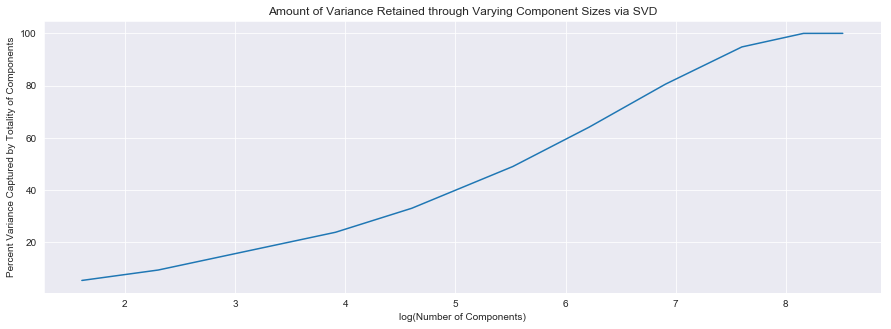

In [326]:
# graphing SVD analysis

sns.set_style('darkgrid')
plt.figure(figsize=(15,5))

sns.lineplot(x='log(Number of Components)', 
             y='Percent Variance Captured by Totality of Components', 
             data=seaborndf,
            markers=component_log)
plt.title('Amount of Variance Retained through Varying Component Sizes via SVD')
plt.show()

__Analysis:__ Based on this logarithmic analysis, you have to pile on the components to retain variance. Judging by the values found in `variance_explained_percent`, when compared to `component_datapoints`, __580 components__, or approximately 10% of the feature space, sounds good to me for the following:

---
---
# Table of Contents for Remainder of Project

1. Setting up X Input Data for Modeling
    - Creating SVD-Truncated feature space
    - Create separate 2D SVD-Truncated feature space for graphing (may need to do PCA...)
    - Perform LSA unsupervised feature analysis (separate from unsupervised clustering)
    - Do all of the above for testing feature space too
<br> <br>
2. Unsupervised Data Modeling
    - K-Means clustering
        - K-Elbow analysis
        - Mini-batch sampling
    - Mean-shift clustering
    - t-SNE clustering
    - Analysis and comparison
<br> <br>
3. Unsupervised Data Modeling for Testing Set
    - Same unsupervised modeling as above
    - Analysis and comparison/contrast with training set
<br> <br>
4. Dataset Preparation for Supervised Modeling
    - Creation of supervised modeling dataset (X, y)
    - Scaling and Transformation of feature space
<br> <br>
5. Supervised Classification Modeling
    - Logistic Regression with LASSO and Ridge penalties
    - K-Nearest Neighbors
    - Random Forest
    - AdaBoosting Ensemble Model
<br> <br>
6. Final Analysis
    - Discussion of best models and shortcomings
    
---
---

# 1. Setting up X

In [328]:
# STEP 1: SETTING UP DIMENSION-REDUCED DATA

# Set up vectorized LSA for input and unsupervised LSA analysis

# although same dimensionality reduction, 
# making two pipelines to get two different variance ratios (see bottom of cell)
svd1=TruncatedSVD(580)
svd2=TruncatedSVD(580)

lsa1 = make_pipeline(svd1, Normalizer(copy=False))
lsa2 = make_pipeline(svd2, Normalizer(copy=False))

X_train_lsa = lsa1.fit_transform(tfidflemma_vectorized_df_train)

X_test_lsa = lsa2.fit_transform(tfidflemma_vectorized_df_test)

#-------------------------------------------------------
'''
While 580 components is a good reduced feature space 
for our vectorized datasets, we need to graph in 2D,
(we *can* do 3D, but it's not necessary for this kind of data).
Therefore, we need to truncate again into 2 dimensions for purposes of graphing
'''

svd_graph=TruncatedSVD(2)
lsa_graph = make_pipeline(svd_graph, Normalizer(copy=False))

X_train_lsa_graph = lsa_graph.fit_transform(tfidflemma_vectorized_df_train)
X_test_lsa_graph = lsa_graph.fit_transform(tfidflemma_vectorized_df_test)

#--------------------------------------------------------

variance_explained_train = svd1.explained_variance_ratio_
total_variance_train = variance_explained_train.sum()

variance_explained_test = svd2.explained_variance_ratio_
total_variance_test = variance_explained_test.sum()

print("Percent variance captured by the totality of the components for the TRAINING dataset: ",
      round(total_variance_train*100, 4))

print("\nPercent variance captured by the totality of the components for the TESTING dataset: ",
      round(total_variance_test*100, 4))


Percent variance captured by the totality of the components for the TRAINING dataset:  67.594

Percent variance captured by the totality of the components for the TESTING dataset:  88.379


In [331]:
X_train_lsa.shape

(3750, 580)

### LSA Analysis

We are able to gain some insight into which input LSA components provide the greatest explanation of variance in the dataset, and which authors' variances are being explained. This is just preliminary analysis before delving into the real unsupervised machine learning analysis.

In [337]:
# finding components in light of AUTHOR
components_train = pd.DataFrame(X_train_lsa,index=df_train['Author'])
components_test = pd.DataFrame(X_test_lsa,index=df_test['Author'])

# five example components:
for i in range(5):
    print('\nComponent {} for Training Set:\n'.format(i))
    print(components_train.loc[:,i].sort_values(ascending=False)[:5])


Component 0 for Training Set:

Author
Mark Bendeich      0.649276
Graham Earnshaw    0.632674
Eric Auchard       0.630504
Bernard Hickey     0.624931
Bernard Hickey     0.621308
Name: 0, dtype: float64

Component 1 for Training Set:

Author
Peter Humphrey    0.743966
Peter Humphrey    0.710732
William Kazer     0.706919
Tan Ee            0.703369
Peter Humphrey    0.699339
Name: 1, dtype: float64

Component 2 for Training Set:

Author
David Lawder    0.561701
David Lawder    0.556036
David Lawder    0.554305
David Lawder    0.553527
David Lawder    0.551263
Name: 2, dtype: float64

Component 3 for Training Set:

Author
David Lawder    0.598727
David Lawder    0.595361
David Lawder    0.585853
David Lawder    0.583259
David Lawder    0.583176
Name: 3, dtype: float64

Component 4 for Training Set:

Author
Sarah Davison    0.374223
Sarah Davison    0.355031
Tan Ee           0.354134
Todd Nissen      0.351394
David Lawder     0.349255
Name: 4, dtype: float64


__Analysis:__ Here we can see which authors are most similar to each other in light of the 580 (rather abstract) components. 

We can safely conclude that _at least in some aspects_, no one quite writes like David Lawder!

In [338]:
for i in range(5):
    print('\nComponent {} for Training Set:\n'.format(i))
    print(components_test.loc[:,i].sort_values(ascending=False)[:5])


Component 0 for Training Set:

Author
Kevin Drawbaugh    0.580515
Nick Louth         0.563699
Eric Auchard       0.556404
Graham Earnshaw    0.554592
Tim Farrand        0.553483
Name: 0, dtype: float64

Component 1 for Training Set:

Author
Peter Humphrey    0.761377
Peter Humphrey    0.734077
Peter Humphrey    0.723136
Peter Humphrey    0.704783
Benjamin Kang     0.693950
Name: 1, dtype: float64

Component 2 for Training Set:

Author
Heather Scoffield    0.467673
Heather Scoffield    0.467673
Heather Scoffield    0.457429
Darren Schuettler    0.456426
Darren Schuettler    0.448331
Name: 2, dtype: float64

Component 3 for Training Set:

Author
Darren Schuettler    0.650693
Darren Schuettler    0.648150
Lydia Zajc           0.595493
Darren Schuettler    0.592159
Lydia Zajc           0.591638
Name: 3, dtype: float64

Component 4 for Training Set:

Author
William Kazer      0.424682
Graham Earnshaw    0.414584
Graham Earnshaw    0.410696
Graham Earnshaw    0.408224
Graham Earnshaw    0.3

__Analysis:__ Components appear to be much more consistent in the training set. This makes sense, as we know that LSA explains 20% more variance in the testing dataset than in the training dataset.  This is likely due to the __curse of dimensionality.__ Flattening thousands of vectors down to 580 components will result in crowding and overlapping of data, thus making it more difficult to discern text from Author A from Author B.

Because the testing feature space (n=5825) was originally a little over half of that of the training feature space (n=10854), it can work with 580 components more easily.  This is a bias to be taken into account when moving forward.

In [397]:
# This is as good of a time as ever to instantiate training and testing sets
X_train = components_train.copy().reset_index()
X_test = components_test.copy().reset_index()
y_train = df_train['AuthorNum']
y_test = df_test['AuthorNum']

In [402]:
# Taking target variable out of feature space
X_train = X_train.drop('Author', axis=1)
X_test = X_test.drop('Author', axis=1)

# 2. Unsupervised Learning - Clustering Analyses

Clustering analysis is meant to find which features are most similar to each other (and in the same vein, which ones are most dissimilar to each other). We can analyze which features fall into which clusters via a `pd.crosstab` analysis.

## K-Means

K-Means Clustering is an iterative trial and error process that minimizes a means distance between similar points. The "K" is the number of cluster points to designate. But how do we know what is the number of clusters that best accurately describes our data? 

__Answer:__ Whichever number of clusters that yields the highest __Silhouette Score.__

---

### What is a Silhouette Score?

A Silhouette value is a distance measure of a sample's distance to its cluster's center (a) and its distance to the center of the nearest cluster that the sameple is not a part of (b). A __Silhouette Coefficient__ is the average of all of these values for a given cluster. [As used in sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), a __Silhouette Score__ is the average of all Silhouette Coefficients across all clusters.

Silhouette Coefficients (and by nature of the metric, Silhouette Scores too) range from (-1,1), with "1" being the best score. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In short, a silhouette score is a __measure of how accurate the clustering is.__ 

---

To determine the K that yields the highest Silhouette Score, we will use the __K-Elbow Visualizer__. The "Elbow Method" is a simple iterative method that measures the accuracies for a range of k-sized clustering.  The point of inflection (the "elbow" of the graph) is usually the indicator that the model fits best with that point (in this case, that the model fits best with that particular k-number of clusters).

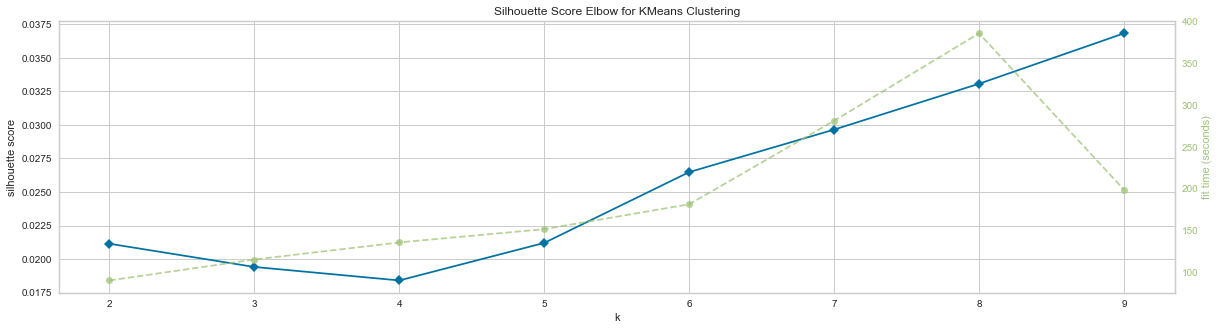

In [340]:
# K-MEANS CLUSTERING

# relative K-Means imports

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Additional import for the KElbowVisualizer method 
from yellowbrick.cluster import KElbowVisualizer

#---------------------------------------------------------

# Instantiate a scikit-learn K-Means model 
# really cranking on these iterations, 
# because I have yet to see any overfitting or significant computational overload...

# ...with PCA. Fitting the model via LSA makes it take 10+ minutes to run

model = KMeans(n_init=500, max_iter=500000, tol=0.000001, random_state=42)

#fit model - preprocessing already complete, 
# so no dimensionality done here

model.fit(X_train_lsa)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

# Fit the data and visualize 

plt.figure(figsize=(20,5))
visualizer.fit(X_train_lsa) 
visualizer.poof() 

In [342]:
# saving the above graph because that calculation took forever
# commented out as to do only once...

#visualizer.poof(outpath='D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/K-MeansElbowTRAIN.png')

<Figure size 576x396 with 0 Axes>

__Analysis:__ The good news is that there is a clear trend that more clusters yields a higher Silhouette Score. The bad news is that the Silhouette Score is dismal; it does not exceed 5%.

As you will see below, __LSA unfortunately has a really tough time with clustering.__  `StandardScaler()` and other pipeline scaling makes no difference. I'll be honest: I'm not sure why. Perhaps LSA components retain their shape during the dimensionality reduction, and in doing so, lose a lot of variance. 

PCA does not do that: it aims to retain its variance during the dimensionality reduction. For clustering models, we will use PCA. However, we will go back to LSA once unsupervised learning is done.

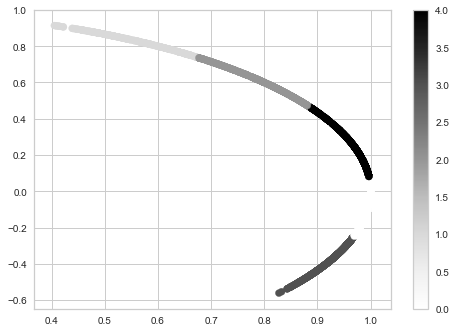

Author,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Cluster Label,,,,,,,,,,,,,,,,,,,,,
0,57,53,60,4,39,32,44,46,45,17,...,50,32,12,1,38,2,25,25,53,3
1,0,0,0,9,0,0,0,0,0,0,...,1,0,27,11,0,56,0,0,0,7
2,0,0,0,52,0,0,0,0,0,0,...,2,0,19,45,0,11,0,0,0,35
3,4,17,14,0,35,43,29,28,28,58,...,9,43,0,0,37,0,50,50,20,0
4,14,5,1,10,1,0,2,1,2,0,...,13,0,17,18,0,6,0,0,2,30


In [346]:
# using the df_test set for this example
# The example shows that LSA is NOT GOOD for clustering - stick with PCA

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()

# retaining LSA reduction, but adding StandardScaler

kmeans = KMeans(n_clusters=5, random_state=42)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans).fit(X_train_lsa_graph)
labels = pipeline.predict(X_train_lsa_graph)


#---------------------------------------------------------------------

y = df_train['AuthorNum']
dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters})

# Plotting kMeans
plt.scatter(x=X_train_lsa_graph[:, 0], y=X_train_lsa_graph[:, 1], c=labels)
plt.colorbar()
plt.show()


ct

In [348]:
# re-running the model but with PCA and not LSA
# setting up PCA

X_pca = PCA(2).fit_transform(tfidflemma_vectorized_df_train)
X_pca_test = PCA(2).fit_transform(tfidflemma_vectorized_df_test)

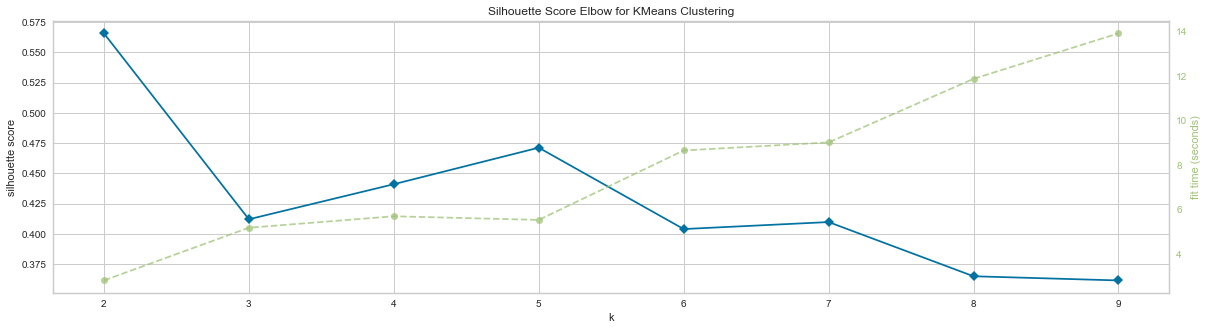

In [349]:
# redoing K-Elbow analysis with the new feature space

model = KMeans(n_init=500, max_iter=500000, tol=0.00001, random_state=42)

# re-instantiating the visualizer model and plotting it
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

plt.figure(figsize=(20,5))
visualizer.fit(X_pca) 
visualizer.poof() 

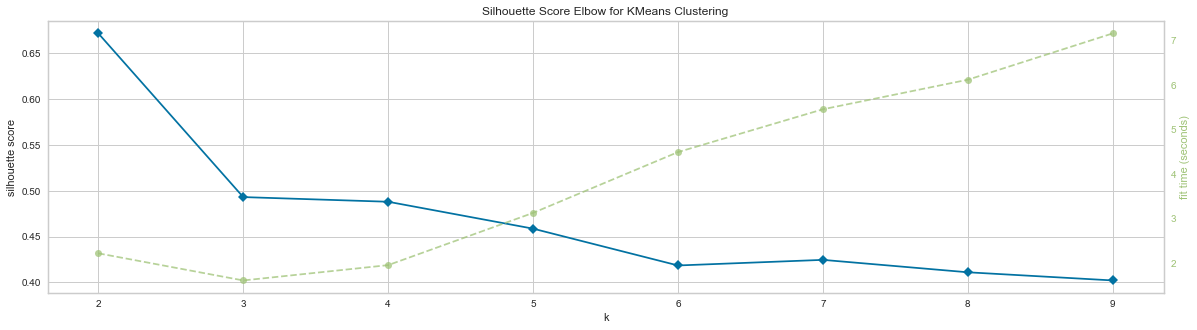

In [409]:
# doing same for testing set:

# redoing K-Elbow analysis with the new feature space

model = KMeans(n_init=500, max_iter=500000, tol=0.00001, random_state=42)

# re-instantiating the visualizer model and plotting it
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

plt.figure(figsize=(20,5))
visualizer.fit(X_pca_test) 
visualizer.poof() 

__Analysis:__ Significantly better with PCA for both training and testing datasets.  Now that we know how many cluster centers to do (__k=2 has the highest Silhouette Score)__, we can finally do clustering right...

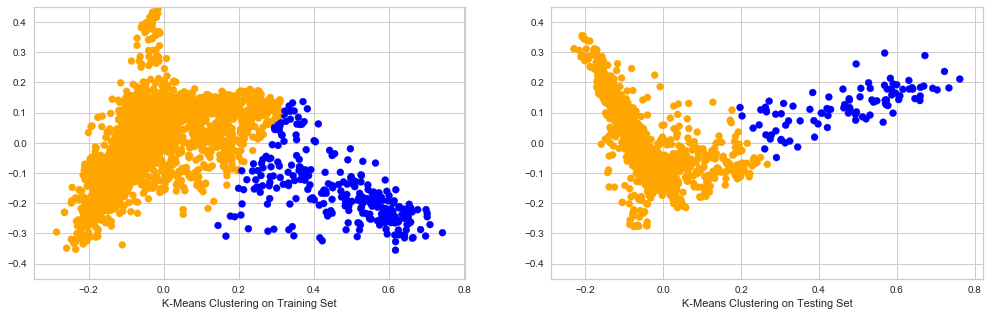

Training cluster 0 has center coordinates of: (-0.21, 0.1)
Training cluster 1 has center coordinates of: (2.79, -1.25)

Crosstab analysis for Training dataset is:
 Author         0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  \
Cluster Label                                         ...                       
0              75  75  75  73  75  75  75  75  75  75 ...  75  75  30  65  75   
1               0   0   0   2   0   0   0   0   0   0 ...   0   0  45  10   0   

Author         45  46  47  48  49  
Cluster Label                      
0              12  75  75  75  63  
1              63   0   0   0  12  

[2 rows x 50 columns]


Testing cluster 0 has center coordinates of: (-0.24, -0.09)
Testing cluster 1 has center coordinates of: (2.88, 1.02)

Crosstab analysis for Testing dataset is:
 Author         0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  \
Cluster Label                                         ...                       
0              25 

In [411]:
# re-doing K-Means given (1) PCA is the way to go and 
# (2) we know that K=2 is the best score for clustering

# setting up model
X_pca = PCA(2).fit_transform(X_train)
X_pca_test = PCA(2).fit_transform(X_test)

scaler = StandardScaler()
kmeans1 = KMeans(n_clusters=2, n_init=500, max_iter=500000, tol=0.0001)
kmeans2 = KMeans(n_clusters=2, n_init=500, max_iter=500000, tol=0.0001)

pipeline1 = make_pipeline(scaler, kmeans1).fit(X_pca)
labels1 = pipeline1.predict(X_pca)

pipeline2 = make_pipeline(scaler, kmeans2).fit(X_pca_test)
labels2 = pipeline2.predict(X_pca_test)

#-----------------------------------------------------------------------

# should've adjusted this a while ago...
pd.set_option('display.max_colwidth', 250)

#-----------------------------------------------------------------------

dfkmeans1 = pd.DataFrame({'Cluster Label':labels1, 'Author':y_train})
ct1 = pd.crosstab(dfkmeans1['Cluster Label'], dfkmeans1['Author'])

dfkmeans2 = pd.DataFrame({'Cluster Label':labels2, 'Author':y_test})
ct2 = pd.crosstab(dfkmeans2['Cluster Label'], dfkmeans2['Author'])

#forcing colors

color_list1 = []
color_list2 = []

for value in labels1:
    if value == 0:
        color_list1.append('orange')
    else:
        color_list1.append('blue')
        
for value in labels2:
    if value == 0:
        color_list2.append('orange')
    else:
        color_list2.append('blue')

#--------------------------------------------------------
# setting up analysis to obtain cluster center coordinates

cluster_centers1 = kmeans1.cluster_centers_
xcenters1 = cluster_centers1[:,0]
ycenters1 = cluster_centers1[:,1]
xcenlist1 = list(xcenters1)
ycenlist1 = list(ycenters1)


cluster_centers2 = kmeans2.cluster_centers_
xcenters2 = cluster_centers2[:,0]
ycenters2 = cluster_centers2[:,1]
xcenlist2 = list(xcenters2)
ycenlist2 = list(ycenters2)

#------------------------------------------------------------

# Plotting kMeans

plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=color_list1)
plt.ylim(-.45,.45)
plt.xlabel('K-Means Clustering on Training Set')

plt.subplot(1,2,2)
plt.scatter(x=X_pca_test[:, 0], y=X_pca_test[:, 1], c=color_list2)
plt.ylim(-.45,.45)
plt.xlabel('K-Means Clustering on Testing Set')

plt.show()

#-------------------------------------------------------------
for i in range(0, len(xcenlist1)):
    print('Training cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist1[i], 2), 
                                                                  round(ycenlist1[i], 2)))

print('\nCrosstab analysis for Training dataset is:\n', ct1)
    
print('\n')

for i in range(0, len(xcenlist)):
    print('Testing cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist2[i], 2), 
                                                                  round(ycenlist2[i], 2)))


print('\nCrosstab analysis for Testing dataset is:\n', ct2)

__Analysis:__

It appears the explanatory power of these clusters is limited. For both the training and testing datasets, most of the authors are clustered in Cluster 0. While this explains that the ones primarily clustered in Cluster 1 suggest special characteristics, it does not give much information for all the authors clustered in Cluster 0.

---

While visualization is fun, it limits our components to 2 dimensions, which severely impacts our variance. We can still do cross-tabs with higher dimensions. To do this, we will implement

## Mini-batch K-Means



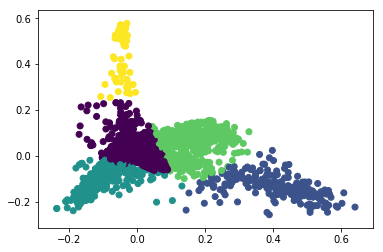

Comparing k-means clusters against the data:


Author,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Cluster Label,,,,,,,,,,,,,,,,,,,,,
0,74,41,42,7,35,35,50,26,41,43,...,72,53,19,7,34,6,54,11,46,12
1,0,0,0,0,0,0,0,0,0,0,...,0,0,40,5,0,59,0,0,0,3
2,1,34,33,1,40,40,25,5,34,32,...,0,22,9,0,41,0,21,64,6,4
3,0,0,0,67,0,0,0,0,0,0,...,3,0,7,63,0,10,0,0,0,56
4,0,0,0,0,0,0,0,44,0,0,...,0,0,0,0,0,0,0,0,23,0


In [287]:
# K-Means clustering

# never formally set this variable...
y = df_train['AuthorNum']

#-------------------------------------------------------------------
'''
Remember, if we are graphing the clusters, 
we need to do it in a 2D space!

As an additional bonus, fewer components means
faster modeling convergence!
'''

kmeans = KMeans(n_clusters=5, n_init=50, max_iter=50000, tol=0.0001, random_state=42)

kmeans.fit(X_train_lsa_graph)

labels = kmeans.predict(X_train_lsa_graph)

# Create a DataFrame with cluster labels and Classes as columns: df
dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})

# Create crosstab: ct
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

# Plotting kMeans
plt.scatter(X_train_lsa_graph[:, 0], X_train_lsa_graph[:, 1], c=labels)
plt.colorbar() # allows for identification of which color pertains to which cluster number

plt.show()

# Check the solution against the crosstab data.
print('Comparing k-means clusters against the data:')
ct

# CLUSTERING ANALYSIS

Looking at which vectorized features are the biggest influencers.

Here, we will be using *x\_train\_tfidf\_vectorized* as the input data. Tfidf is a measure of frequency, which means the proportions of the raw counts (found in CountVectorized()) are the same among datapoints, but the frequency character of the dataset naturally allows scaling that accounts for any particular outliers, which would otherwise negatively affect clustering.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [ ]:
y = df_train['AuthorNum']
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()

X_pca = PCA(2).fit_transform(df_train_tfidf_vectorized) # gigantic feature space

# PCA spreads data out (as a result of lower dimensionality, don't ask)
# Normalizing/standardscaling is just needed for this - otherwise, it will throw a ValueError otherwise.

kmeans = KMeans(n_clusters=5, random_state=42)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans).fit(X_pca)

# Calculate the cluster labels: THIS IS THE OUTPUT YOU ARE LOOKING AT!!!!!!!!!!!!********
labels = pipeline.predict(X_pca)

# Create a DataFrame with cluster labels and Classes as columns: df
dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})

# Create crosstab: ct
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

# Plotting kMeans
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')

## Calculate predicted values.
#y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_pca)

# Plot the solution.
#plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the crosstab data.
print('Comparing k-means clusters against the data:')
ct

In [ ]:
# problem with above is that while cluster points scaled and transformed
# cluster centers refused to do so

# don't need scaling or normalization because all tfidf values are between 0 and 1 anyway

#------------------------------------------------------------------------------------

# K-Means, Round 2

X_pca = PCA(2).fit_transform(df_train_tfidf_vectorized) 

kmeans = KMeans(n_clusters=13, n_init=50, max_iter=500000, tol=0.000001)

# Create pipeline: pipeline
#from sklearn.preprocessing import Normalizer
#normalizer=Normalizer()

#pipeline = make_pipeline(normalizer, kmeans).fit_transform(X_pca)
kmeans.fit(X_pca)
labels = kmeans.predict(X_pca) # same as kmeans.labels_ --- I just did it this way


dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

legendlabels = range(0,13)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters,
                        'Labels':[str(label) for label in legendlabels]})

# Plotting kMeans
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=labels)
plt.legend(centerdf.Labels)

# Plotting kMeans centers
plt.scatter(x=xcenters, y=ycenters,
            c='red', marker='x')
plt.show()

for i in range(0, len(xcenlist)):
    print('Cluster {} has center coordinates of: ({}, {})'.format(str(legendlabels[i]), 
                                                                  round(xcenlist[i], 2), 
                                                                  round(ycenlist[i], 2)))

ct

In [ ]:
# importing silhouette score

from sklearn.metrics import silhouette_score 
silhouette_score(X_pca, labels) # silhouette score for k=13 clusters

In [ ]:
# judging by the graph, silhouette score for K=2 is ~58%.
# welp, that settles it! going back and doing a final K-Means with K=2

#------------------------------------------------------------------------------------

# K-Means, Round 3

X_pca = PCA(2).fit_transform(df_train_tfidf_vectorized) 

kmeans = KMeans(n_clusters=2, n_init=500, max_iter=500000, tol=0.000001, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.predict(X_pca)

dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

legendlabels = range(0,2)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters,
                        'Labels':[str(label) for label in legendlabels]})

#------------------------------------------------------------------------

#matplotlib thought "black and white" were good plotting colors for no reason, so that's neat...

color_list = []
for value in labels:
    if value == 0:
        color_list.append('orange')
    else:
        color_list.append('blue')

# Plotting kMeans
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=color_list) 

# Plotting kMeans centers
plt.scatter(x=xcenters, y=ycenters,
            c='red', marker='x')
plt.show()

for i in range(0, len(xcenlist)):
    print('Cluster {} has center coordinates of: ({}, {})'.format(str(legendlabels[i]), 
                                                                  round(xcenlist[i], 2), 
                                                                  round(ycenlist[i], 2)))

ct

In [ ]:
df_crosstab_analysis = pd.DataFrame({'Author':df_train['Author'].unique()})

cluster_fraction_list = []
cluster_final_list = []

for i in range(0,50):
    cluster0_count = ct[i].iloc[0]
    cluster1_count = ct[i].iloc[1]
    cluster_total = 75
    
    if cluster0_count > cluster1_count:
        cluster0avg = cluster0_count / cluster_total
        cluster_fraction_list.append(cluster0avg)
        cluster_final_list.append(0)
        
    else:
        cluster1avg = cluster1_count / cluster_total
        cluster_fraction_list.append(cluster1avg)
        cluster_final_list.append(1)
        

df_crosstab_analysis['Cluster No. Classification'] = pd.Series(cluster_final_list)
df_crosstab_analysis['Percent of Author in the Cluster Classification'] = pd.Series(cluster_fraction_list)
df_crosstab_analysis = df_crosstab_analysis.sort_values(by=['Cluster No. Classification',
                                                           'Percent of Author in the Cluster Classification'],
                                                        ascending=False)

# just did this manually
print('The percentage of Authors found to be in Cluster 1 more than in Cluster 0 is 20% (10/50 total Authors).')

df_crosstab_analysis

__Analysis:__ 

Again, only 20% of the `df_train` dataset can be characterized as falling into Cluster 1. More so, out of that 20%, only two authors (37 - Peter Humphrey and 45 - Tan Ee) were classified in Cluster 1 by more than 75%. These results come from K=2, which has the highest silhouette score of ~58%...

---
---

# So what now?

Obtaining the highest silhouette score of ~58% leaves us at a point where there is an expected upper-limit to model accuracy moving forward. Did we do something wrong?

I propose yes. Yes we did.

Thinkful's Capstone Project instructions appear to place the cart before the horse. According to the instructions (which are listed in the beginning of this project): "The _first technique_ is to create a series of clusters. ... _Next_, perform some unsupervised feature generation and selection using techniques covered in this unit and elsewhere in the course."

It is a fact that dimensionality reduction and proper scaling are _required_ for clustering. While not synonymous, dimensionality reduction goes hand in hand with feature selection and generation; the dimensionality reduction algorithm is created "new" composite features as projections. From there, we can cluster and perform unsupervised learning.

---
---

# Table of Contents for Remainder of Project

1. Re-vectorize data using tfidf again, but with different (better) hyperparameters.


2. Use gensim's `word2vec` to perform unsupervised learning on the dataset (this model has dimensionality reduction built-in as a hyperparameter).


3. Reduce dimensionality using the more appropriate dimensionality reduction algorithm, _Latent Semantic Analysis (LSA)_, for the remainder of unsupervised learning analysis.
    - retain original `df_train` for aggregate number features. This will be separately clustered and analyzed.
    
    
4. Apply clustering models:
    - K-Means (again)
    - Spectral Clustering
    - t-SNE


5. Perform any feature selection, testing whether to include aggregate number features in the vectorized DataFrame.


6. Build and fit supervised classification models.


7. Test fitted models on vectorized and dimensionality-reduced testing data.


8. Apply test data to previously used clustering models.
    - Compare and contrast the results with those of the training data.

In [ ]:
# STEP 0: Load the data
# I have since restarted the kernel
# luckily, I saved my text analysis df's

df_train = pd.read_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/COMPLETE_NLP-train.csv')
df_test = pd.read_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/COMPLETE_NLP-test.csv')

df_train.head(3)

In [ ]:
# not so lucky, it appears that python doesn't know what to do with lemmatized text as that is a spacy datatype
# gotta re-clean?...

# STEP 1: DATA CLEANING
# wanted to do something more comprehensive than the above text cleaner function

df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace('\'', ''))
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace('[', ''))
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace(']', ''))
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace(',', ''))
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace(r'\\n', ''))
df_train['Lemmatized Text'][1]

In [ ]:
import re

df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace('.', '')) # tried to do re
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace('-', ' '))# but didn't work...
df_train['Lemmatized Text'] = df_train['Lemmatized Text'].apply(lambda x: x.replace('\\n', ''))
df_train['Lemmatized Text'][1]
                                                                

In [ ]:
# it's...fine.
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace('\'', ''))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace('[', ''))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace(']', ''))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace(',', ''))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace('.', ''))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace('-', ' '))
df_test['Lemmatized Text'] = df_test['Lemmatized Text'].apply(lambda x: x.replace('\\n', ''))

In [ ]:
# STEP 2 - RE-VECTORIZING TRAINING DATA

# Instantiate vectorizer model
# input here for demonstration purposes - already imported
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word',
                        ngram_range=(1,1),      # ensuring unigram nature
                        min_df=2,               # only use words that appear at least twice******
                        stop_words='english',   # stop words and lowercase were already done 
                        lowercase=True,         # but it doesn't hurt to do a second time
                        use_idf=True,           # um yeah, that's what we're doing...
                        norm=u'l2',             # Applies a correction factor for imbalanced sized tokens
                        smooth_idf=True         # smooth_idf adds 1 to all document frequencies, 
                       )                        # as if an extra document existed that used every word once.  
                                                # Prevents divide-by-zero errors
    
tfidf_vectors = tfidf.fit_transform(df_train['Lemmatized Text'])
#dense = tfidf_vectors.todense() ----- for a feature space of this size
#denselist = dense.tolist()     ------ fixing sparsity will crash/run out of memory

token_names = tfidf.get_feature_names()

# creating dataframe from vectors (a separate process)
vectorized_df_train = pd.DataFrame(tfidf_vectors.toarray(), columns=token_names)

In [ ]:
vectorized_df_train.head(3)

In [ ]:
# DATAFRAME CLEANING
'''
This vectorized dataframe is extremely sparse.
Trying to do tfidf_vectors.todense() threw a memory error. Not risking that.
Dropping all number columns because we are looking at words, not numbers.
'''
import re

numbertokens = []
dates = [str(x) for x in list(range(1900, 2026))]

for name in token_names:
    num_token = re.findall(r'\d+[^t][^h]', name)
    num_not_date = [x for x in num_token if x not in dates]
    if len(num_not_date) != 0:
        numbertokens.append(num_not_date)
        
print(len(numbertokens))
numbertokens

In [ ]:
# numbertokens is list of lists. Need to undo that
from itertools import chain

numbertokens2 = list(chain.from_iterable(numbertokens))
numbertokens2[:5]

In [ ]:
numbertokens2[25:100]

In [ ]:
print(len(numbertokens2))
print(len(list(set(numbertokens2))))

In [ ]:
# checking for duplicates, there are none
print(len(token_names))
print(len(set(token_names)))

In [ ]:
# TRYING to drop all numerical tokens

for item in numbertokens2 and token_names:
    vectorized_df_train.drop(columns=[item], axis=1, inplace=True)


In [ ]:
# I give up, just manually doing it:
vectorized_df_train = vectorized_df_train.iloc[:,1808:].copy()

In [ ]:
vectorized_df_train.shape

# Feature Analysis and Dimensionality Reduction via LSA

Latent Semantic Analysis (LSA) is a dimensionality reduction method that measures the angles of the vectors via a cosine algorithm. This cosine algorithm essentially creates a normal range between 0 and 1.

For efficiency purposes, dimensionality reduction is crucial for unsupervised learning methods such as clustering.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from nearly 20000 to 150
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(vectorized_df_train) ###### LSA IS THE NAME OF THE MODEL USED HERE!

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of authors our LSA model considers similar, for the first (not top) ***FIVE*** components
components=pd.DataFrame(X_train_lsa,index=df_train['Author'])
for i in range(5):
    print('\nComponent {}:\n'.format(i))
    print(components.loc[:,i].sort_values(ascending=False)[:5])

In [ ]:
components.head(3)

### What does this tell us?

Tells us that no one writes like David Lawder!

It is disheartening, however, to see that the truncation resulted in the retention of only 37% variance. While this is somewhat expected given that we are flattening nearly 20000 features into 150, this is still a significant loss and could play a role in making our future models inaccurate.

In [ ]:
# let's see if LSA can tell us 

# running LSA again with 50 components, like 50 clusters:
svd= TruncatedSVD(50)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(vectorized_df_train) ###### LSA IS THE NAME OF THE MODEL USED HERE!

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

components=pd.DataFrame(X_train_lsa,index=df_train['Author'])


In [ ]:
columnsort = {}
for column in components.columns:
    columndict = {str(column):components[column].max()}
    columnsort.update(columndict)
    
columnsort

In [ ]:
# components 0,1,3,7 had highest numbers:

for i in [0,1,3,7]:
    print('\nComponent {}:\n'.format(i))
    print(components.loc[:,i].sort_values(ascending=False)[:3])

We can use the above to figure out which components best describe a given author.

To do this, we could use `pd.idmax(axis=0)`

# Clustering

Using the above, we have an idea of what kinds of clusterings we expect from authors' writings. Unforntuately, we have to use reduce dimensionality down to 2 if we want to visualize the clusters. SVD is still preferable over PCA because PCA requires a central tendency, and there is no such thing in a sparse vector matrix. On the other hand, PCA retains variance, and we have seen the huge drops in variance explainability with SVD/LSA.

Let's try SVD first.

In [ ]:
# re-doing SVD to get 2 dimensions
svd= TruncatedSVD(2)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(vectorized_df_train)

# K-Means clustering
y = df_train['Author']
kmeans = KMeans(n_clusters=5, n_init=500, max_iter=500000, tol=0.000001, random_state=42)
kmeans.fit(X_train_lsa)
labels = kmeans.predict(X_train_lsa)

dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters})

#------------------------------------------------------------------------


# Plotting kMeans
plt.scatter(x=X_train_lsa[:, 0], y=X_train_lsa[:, 1], c=labels) 

# Plotting kMeans centers
plt.scatter(x=xcenters, y=ycenters,
            c='red', marker='x')
plt.show()

for i in range(0, len(xcenlist)):
    print('Cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist[i], 2), 
                                                                  round(ycenlist[i], 2)))

ct

So as you can see, creating a central tendency for graphing purposes might be better.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()

X_pca = PCA(2).fit_transform(vectorized_df_train) 

kmeans = KMeans(n_clusters=5, n_init=500, max_iter=500000, tol=0.000001, random_state=42)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans).fit(X_pca)

# Calculate the cluster labels
labels = pipeline.predict(X_pca)

dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters})

#------------------------------------------------------------------------


# Plotting kMeans
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=labels) 

plt.show()

for i in range(5):
    print('Cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist[i], 2), 
                                                                  round(ycenlist[i], 2)))

In [ ]:
# importing silhouette score

from sklearn.metrics import silhouette_score 
silhouette_score(X_pca, labels) # silhouette score for k=5 clusters, above

In [ ]:
# doing one more KElbow analysis
from yellowbrick.cluster import KElbowVisualizer

# Instantiate a scikit-learn K-Means model 
# really cranking on these iterations, 
# because I have yet to see any overfitting or significant computational overload...
model = KMeans(n_init=500, max_iter=500000, tol=0.000001, random_state=42)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,21), metric='silhouette', timings=True)

# Fit the data and visualize 

plt.figure(figsize=(20,5))
visualizer.fit(X_pca) 
visualizer.poof() 

# To Do

run mean shift with PCA
run spectral OR affinity with PCA
run t-SNE
---
create feature spaces, incorporating top components from LSA and aggregate numbers from original
DO THE SAME FOR XTEST
run supervised classification models
- lasso/ridge
- knn
- tree model/boosting model
unsupervised modelling on testing dataset
explain classification analyis and compare/contrast models

In [ ]:
# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


# SciPy hierarchical clustering doesn't fit into a sklearn pipeline, so we need to use the 
# normalize() function from sklearn.preprocessing instead of Normalizer.

# Import normalize
from sklearn.preprocessing import normalize
# Normalize the movements: normalized_movements
normalized_movements = normalize(sample_data)
# Calculate the linkage: mergings
mergings = linkage(normalized_movements, method='complete')


# Plot the dendrogram, using varieties as labels
dendrogram(mergings,labels=varieties, leaf_rotation=90,leaf_font_size=6)
plt.show()

In [ ]:
# playing around with the K ---- checking elbow for best number of clusters